In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

# from utils.Auger.SD import Monitoring

from scipy.optimize import curve_fit
from utils.binaries import *
from utils.plotting import *

def parabola(x, a, b, c):
    return a * x**2 + b*x + c

def make_histo_fit(x, y):

    sort_mask = np.argsort(x)
    x, y = x[sort_mask], y[sort_mask]   

    try:
        (a, b, c), pp = curve_fit(parabola, x, y, 
                            bounds=[[-np.inf, 0, 0],[0, np.inf, np.inf]],
                            sigma=np.sqrt(y),
                            p0=[-100, 1, 0],
                            check_finite=True)
    
    except ValueError:
        a, b, c, pp = np.nan, np.nan, np.nan, None

    return (a, b, c), pp

14:20:19 [INFO] utils          -- ( +2679ms) -- import logging
14:20:19 [INFO] utils.binaries -- (    +2ms) -- import numpy as np
14:20:19 [INFO] utils.binaries -- (    +9ms) -- import uncertainties
14:20:19 [INFO] utils.binaries -- (    +2ms) -- import numpy as np
14:20:19 [INFO] utils.binaries -- (    +9ms) -- import uncertainties
14:20:19 [INFO] utils.binaries -- (  +261ms) -- import pandas as pd
14:20:19 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
14:20:20 [INFO] utils.plotting -- ( +1053ms) -- import matplotlib.pyplot as plt
14:20:20 [INFO] utils.plotting -- (  +282ms) -- import seaborn as so
14:20:20 [DBUG] utils.plotting -- (   +11ms) -- font size set to 9.5
14:20:20 [DBUG] utils.plotting -- (    +2ms) -- label size set to 13.0
14:20:20 [DBUG] utils.plotting -- (    +0ms) -- figure size set to [6.6, 3.3]
14:20:20 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
14:20:20 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
14:20:20 [INF

14:20:20 [DBUG] utils.plotting -- (   +18ms) -- font size set to 9.5
14:20:20 [DBUG] utils.plotting -- (    +4ms) -- label size set to 13.0
14:20:20 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [3.3, 2.5]
14:20:20 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
14:20:20 [DBUG] utils.plotting -- (    +0ms) -- usetex set to True


Nadia: -b/(2*a) = 49.5+/-3.0 ADC
NuriaJr: -b/(2*a) = 53.7+/-2.6 ADC


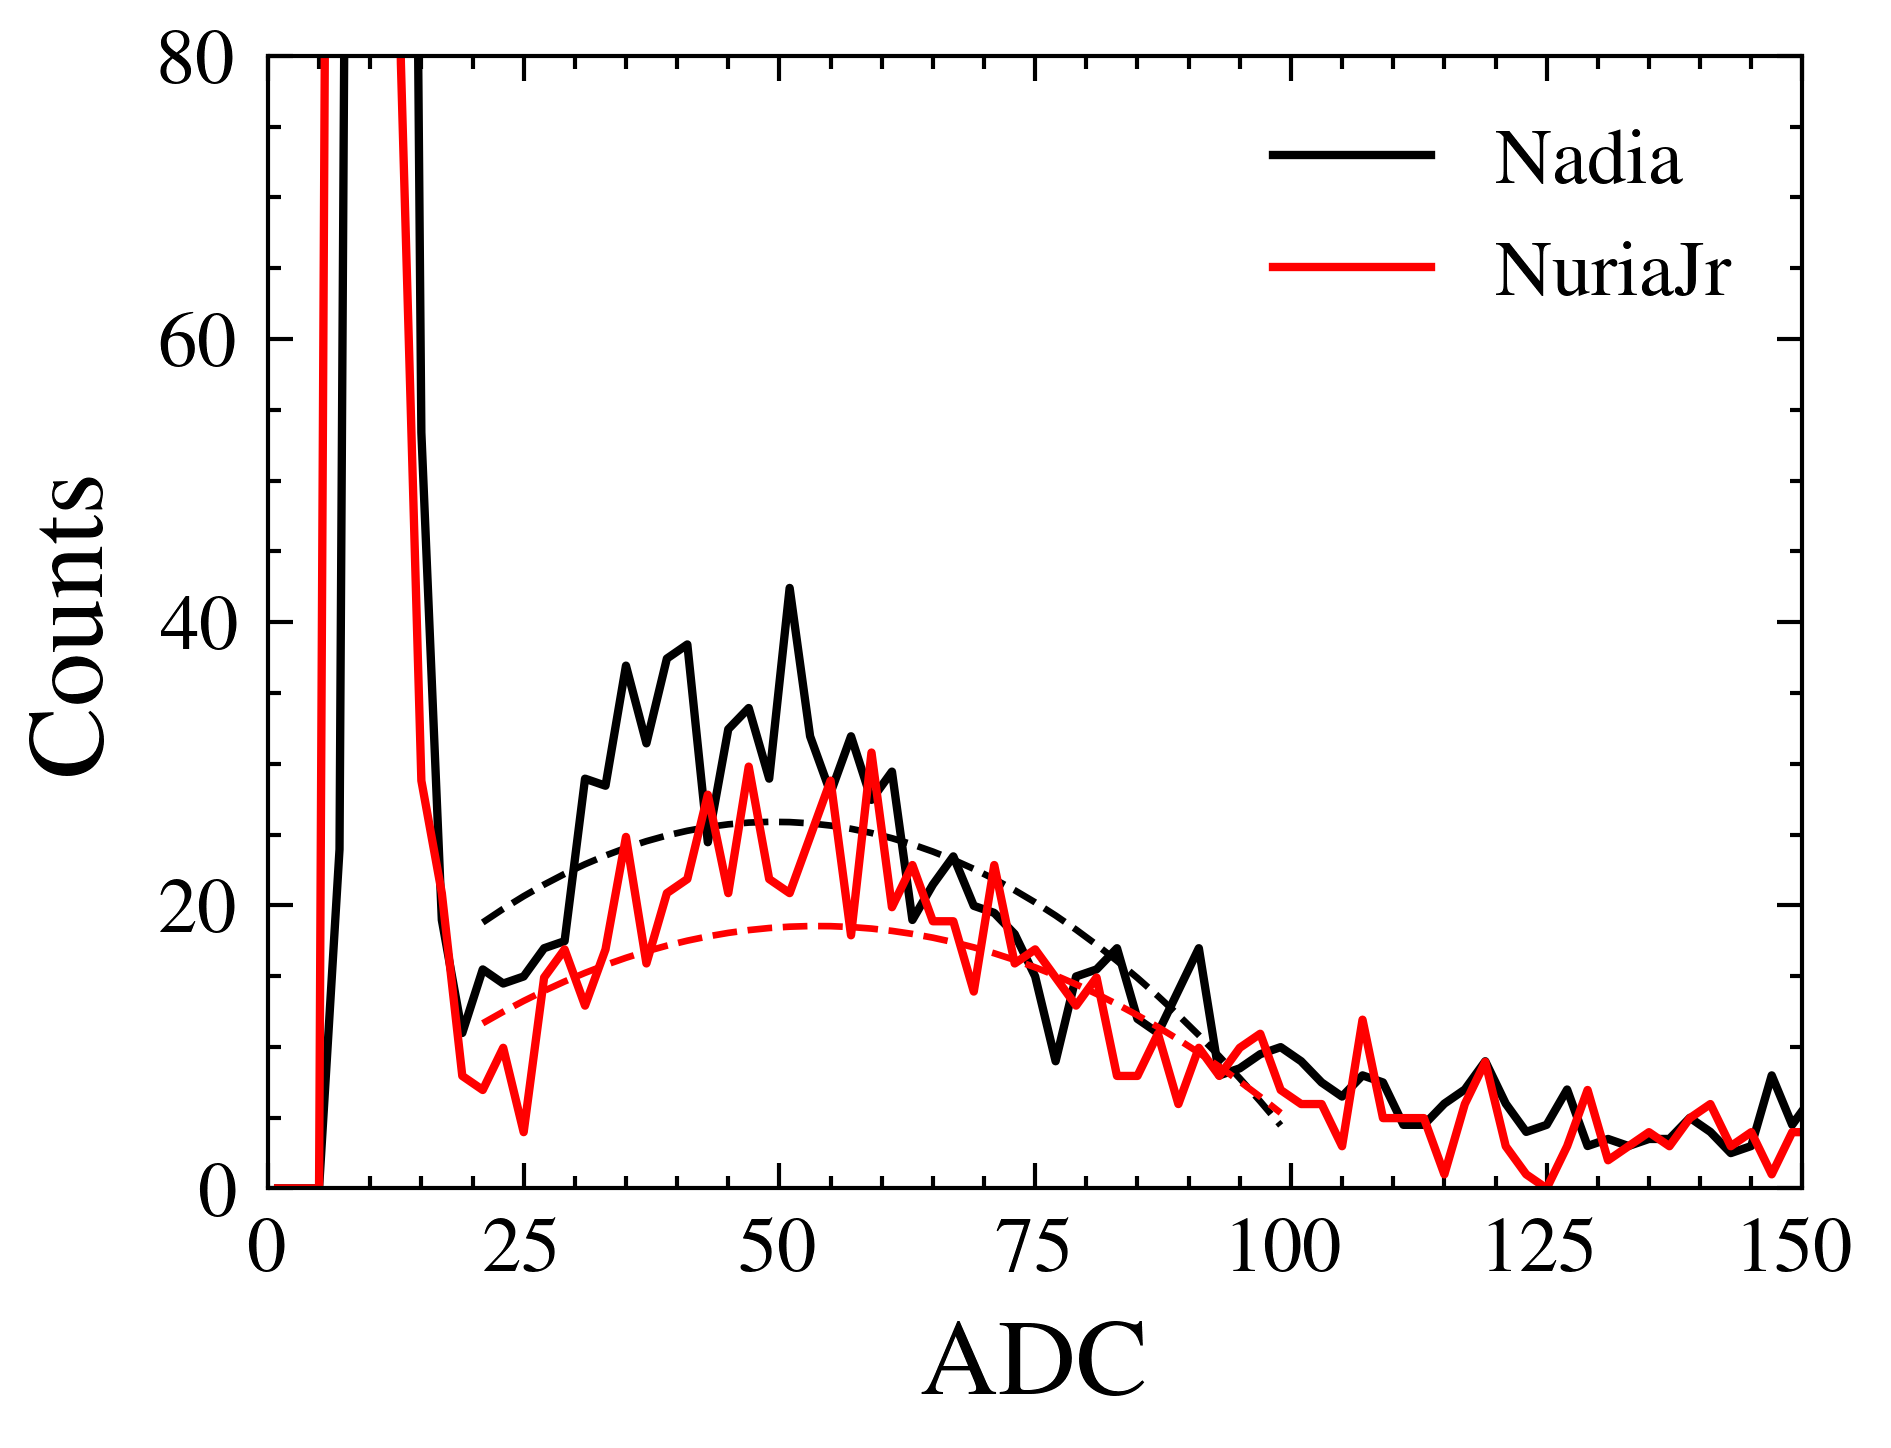

In [2]:
color = ['black', 'red']
n_files = [1433, 720]
mips, histos = [], []

set_plt_style('double tex')

for i, station in enumerate(["Nadia", "NuriaJr"]):

    peaks = np.loadtxt(f'/cr/users/filip/Data/SDMonitHistos/{station}_T1_coinc_histo.txt')
    counts, bins = np.histogram(peaks, bins=140, range=(20, 300))
    counts = counts / (n_files[i] * 5000 * 2048 * 8.33e-9)
    x_fit = (0.5 * (bins[1:] + bins[:-1]))[:40]
    popt, pcov = make_histo_fit(x_fit, counts[:40])
    err_up, err_down = tools.bootstrap_ci(parabola, popt, pcov, x_fit)

    n, all_bins = np.histogram(peaks, bins=150, range=(0, 300))
    plt.plot(0.5 * (all_bins[1:] + all_bins[:-1]), 61 * n / (n_files[i] * 5000 * 2048 * 8.33e-9), c=color[i], label=station, ls='solid')
    plt.plot(x_fit, 61 * parabola(x_fit, *popt), ls='--', lw=0.8, c=color[i])
    # plt.fill_between(x_fit, 61 * err_up, 61 * err_down, alpha=0.1, color=color[i])

    (a, b, c) = uncertainties.correlated_values(popt, pcov)
    mips.append(-b/(2*a))
    histos.append(peaks)

    print(f"{station}: {-b/(2*a) = :.1f} ADC")

# plt.yscale('log')
plt.ylim(0, 80)
plt.xlim(0, 150)
plt.xlabel('ADC')
plt.ylabel("Counts")
plt.legend()

Text(0, 0.5, '$\\sigma_\\mathrm{stat.}\\,/\\,\\mathrm{MIP}_\\mathrm{Peak}$')

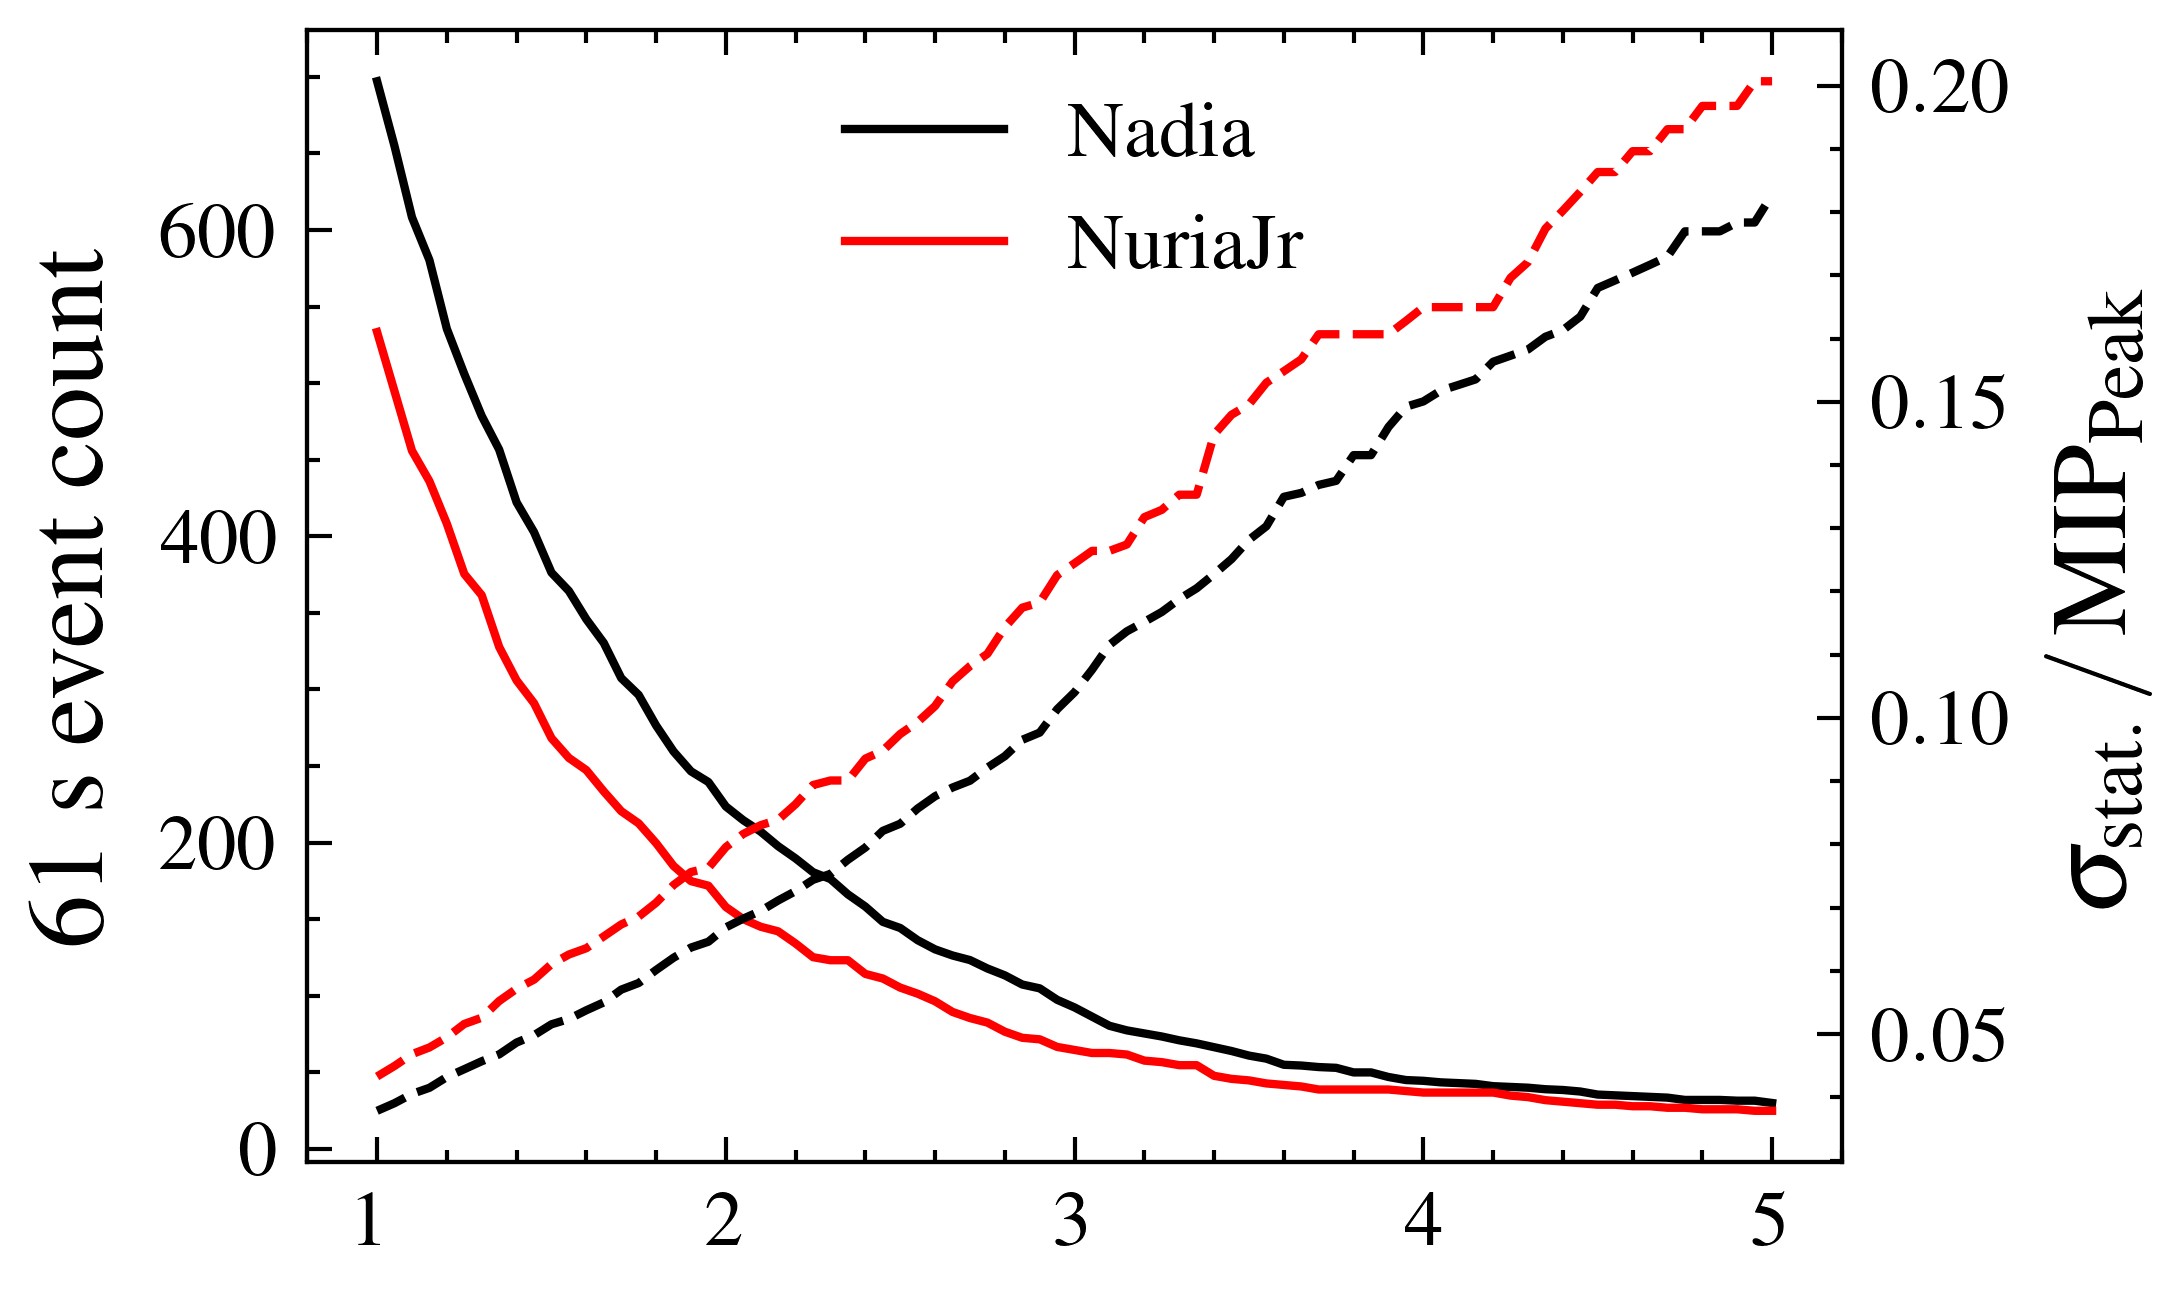

In [3]:
thresholds = np.arange(1.0, 5.01, 0.05)

ax1 = plt.gca()
ax2 = ax1.twinx()
for histo, mip, n_file in zip(histos, mips, n_files):

    event_counts, errors = [], []
    for t in thresholds:
        inclusive_rate = np.sum([c > t * mip.n for c in histo]) / (n_file * 5000 * 2048 * 8.33e-9)
        event_counts.append(61 * inclusive_rate)
        errors.append(1/np.sqrt(61 * inclusive_rate))

    ax1.plot(thresholds, event_counts, ls='solid', label = 'Nadia' if n_file > 1000 else "NuriaJr")
    ax2.plot(thresholds, errors, ls='--')

ax1.legend(loc='upper center')
ax1.set_ylabel("61 s event count")
ax2.set_ylabel("$\sigma_\mathrm{stat.}\,/\,\mathrm{MIP}_\mathrm{Peak}$")

/cr/users/filip/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/cr/users/filip/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Text(0.5, 0, 'threshold / $\\mathrm{MIP}_\\mathrm{Peak}$')

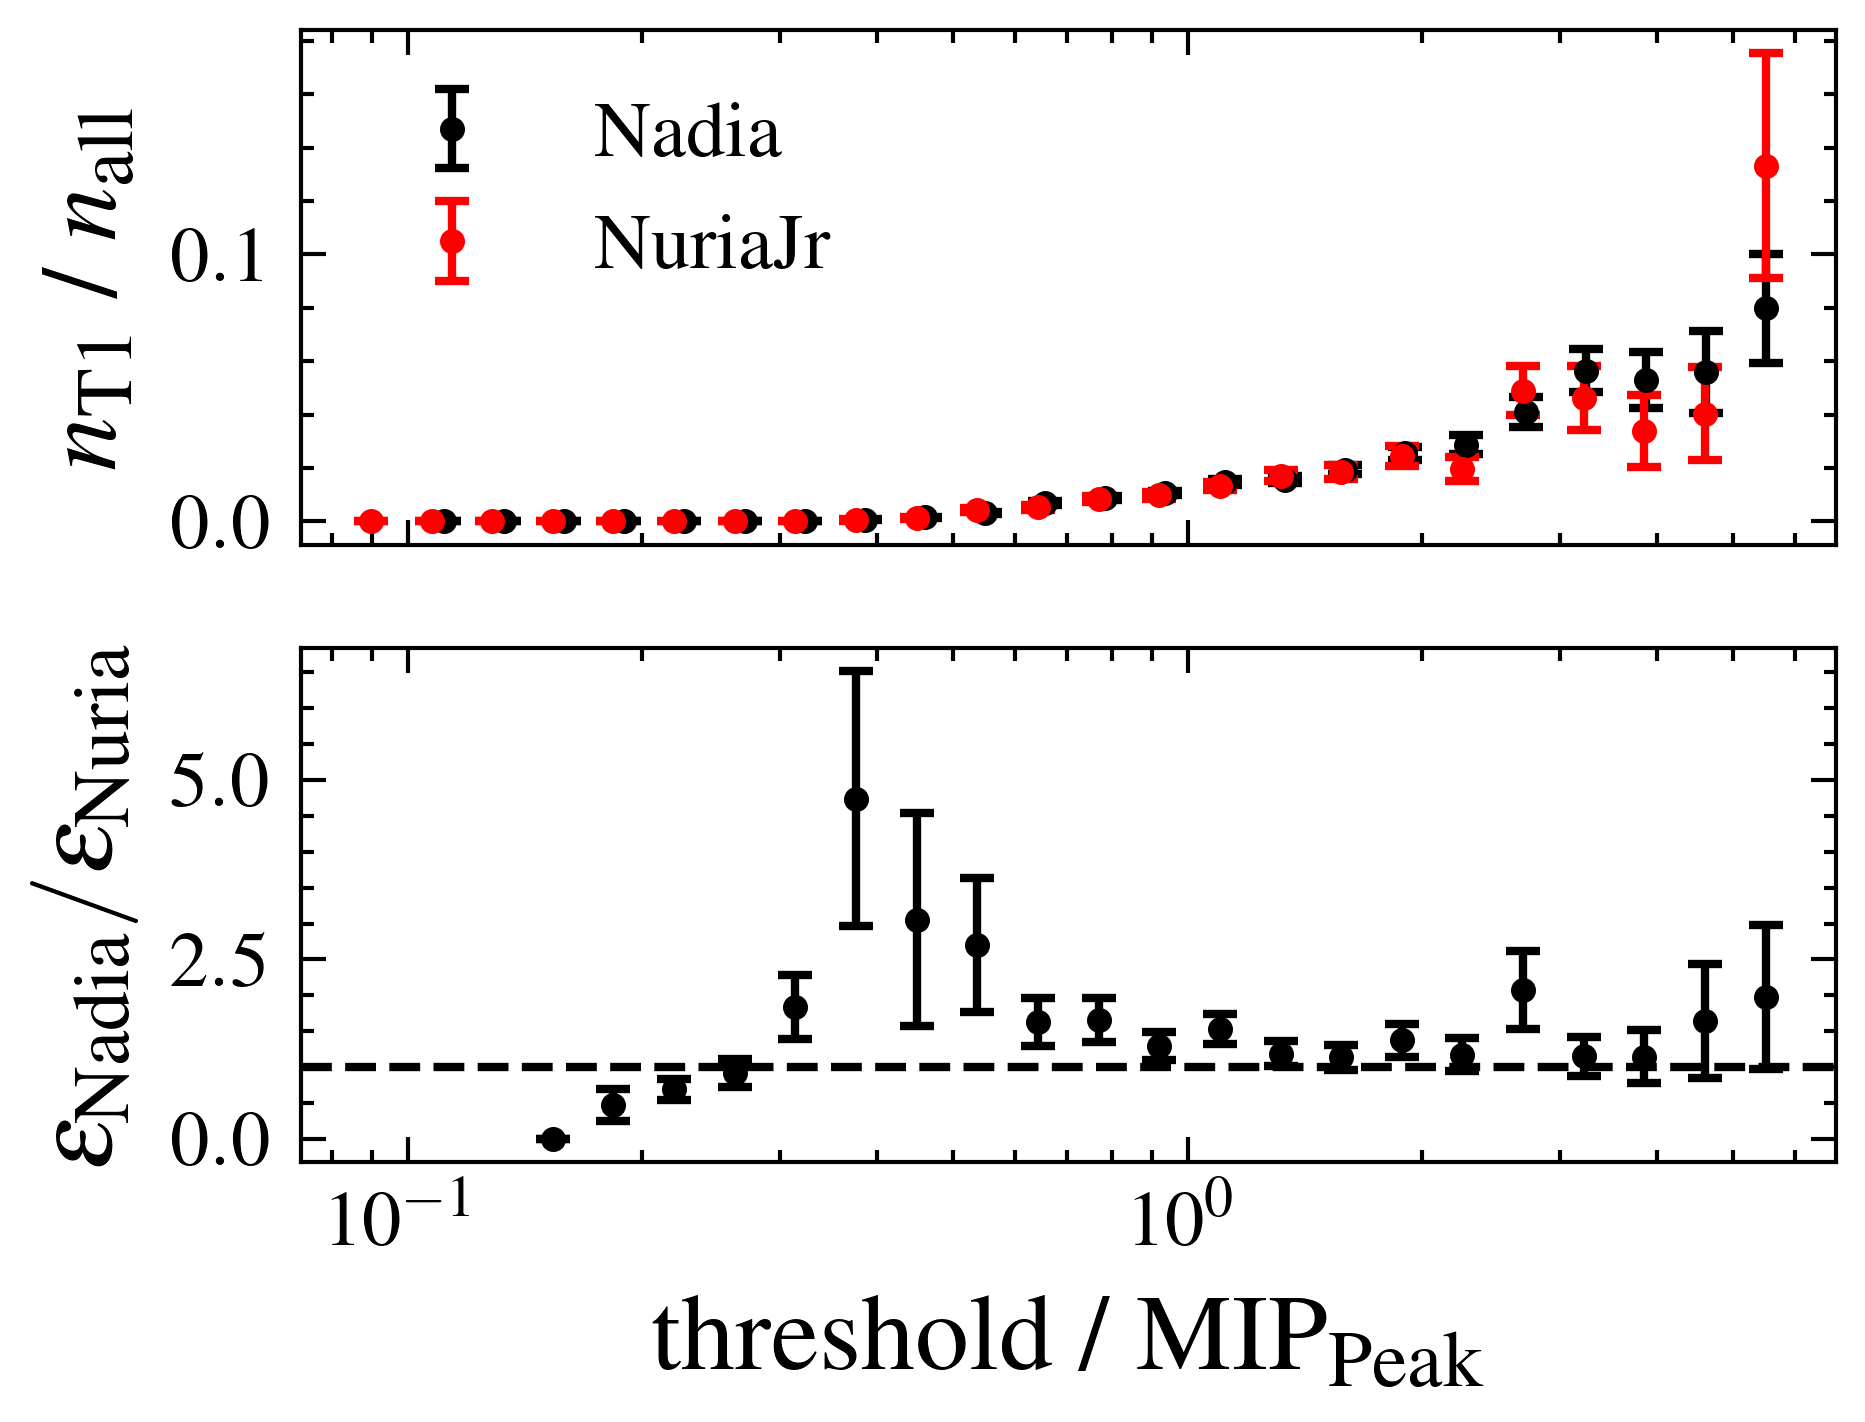

In [19]:
MIP = {'Nadia':             49.5,
       'NuriaJr':           53.7}

ratios = []
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for station in ["Nadia", "NuriaJr"]:
    ssd_only = np.loadtxt(f'/cr/users/filip/Data/StationEfficiencies/{station}FilteredDownsampled_ssd_only.txt')
    ssd_and_t1 = np.loadtxt(f'/cr/users/filip/Data/StationEfficiencies/{station}FilteredDownsampled_ssd_and_t1.txt')

    log_bins = np.geomspace(5e-2, 6 * MIP[station], 50)
    n_ssd, bins = np.histogram(ssd_only, bins=log_bins)
    n_wcd, bins = np.histogram(ssd_and_t1, bins=log_bins)


    x, y, y_errors = [], [], []
    for loc, a, b in zip(0.5 * (log_bins[1:] + log_bins[:-1]) / MIP[station], n_ssd, n_wcd):
        cov = np.array([[np.sqrt(a), -1], [-1, b]])
        (ssd, wcd) = uncertainties.correlated_values((a, b), cov)

        try:
            ratio = wcd / (wcd + ssd)
        except ZeroDivisionError: continue

        ratios.append(ratio)
        y.append(ratio.n)
        y_errors.append(ratio.std_dev)
        x.append(loc)

    ax1.errorbar(x, y, y_errors, label=station, fmt='o', capsize=2)

# plt.xlim(0, 4)

station1, station2 = ratios[:len(ratios) // 2], ratios[len(ratios) // 2:]
ratios = [s1 / s2 if not s2 == 0 else uncertainties.ufloat(np.nan, 1) for s1, s2 in zip(station1, station2)]
ax2.errorbar(x[1:], [y.n for y in ratios], [y.std_dev for y in ratios], fmt='o', capsize=2)
ax2.axhline(1, ls='--')
ax2.set_ylabel("$\epsilon_\mathrm{Nadia} / \epsilon_\mathrm{Nuria}$")

ax1.set_ylabel(r"$n_\mathrm{T1}$ / $n_\mathrm{all}$")
ax1.legend()
ax2.set_xscale('log')
ax2.set_xlabel("threshold / $\mathrm{MIP}_\mathrm{Peak}$")
# plt.yscale('log')